# Common Codes

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
from geojson import dumps
import geojson as g
%matplotlib inline
plt.style.use('ggplot')
import numpy as np
import pandas as pd
#import geoplotlib

In [7]:
#more imports: Ashkan's additions
import gmplot
import plotly.plotly as py
import plotly.graph_objs as go
mapbox_token = 'pk.eyJ1IjoiYXNoa2Fuc2Fib29yaSIsImEiOiJjaXp5djVldTMwM2FtMzNveHRpaTFqdHhyIn0.uVPRMwfIuYE_3j3jRajBFA'

In [7]:
def read_data(path, year):
    """
    reads csv data and returns 4 data frames for the given year
    input: path
    output: 4 data frames (station, status, trip, and weather)
    """
    path = path + '/' + str(year) + '/'
    station = pd.read_csv(path + 'station.csv')
    status = pd.read_csv(path + 'status.csv')
    trip = pd.read_csv(path + 'trip.csv')
    weather = pd.read_csv(path + 'weather.csv')
    
    return station, status , trip, weather

# ZAMIR'S CODES

In [8]:
path = '/Users/admin/project_data_141'
station, status, trip, weather = read_data(path, 2016)

In [9]:
station = station.dropna()

In [10]:
print 'Size of station DF {}'.format(station.shape)
print 'Size of status DF {}'.format(status.shape)
print 'Size of trip DF {}'.format(trip.shape)
print 'Size of weather DF {}'.format(weather.shape)

Size of station DF (67, 7)
Size of status DF (35517185, 4)
Size of trip DF (313689, 11)
Size of weather DF (1830, 24)


In [11]:
trip = trip.rename(columns={'Start Terminal' : 'station_id'})
merged_st = pd.merge(station, trip, on = 'station_id')

### Statistics about bike rides

In [12]:
total_duration = sum(merged_st.Duration)
print 'number of bike rides between 09/01/2015 and 08/31/2016 : {}'.format(len(merged_st['Trip ID']))
print 'averaging about {} minutes per ride'.format(total_duration/(len(merged_st['Trip ID']) *60))
print 'total riding time is {} hours'.format(total_duration/3600)
print 'or {} days'.format(total_duration/(3600 * 24))
print 'or {} years'.format(total_duration / (3600 * 24 * 365))

number of bike rides between 09/01/2015 and 08/31/2016 : 312126
averaging about 13 minutes per ride
total riding time is 71729 hours
or 2988 days
or 8 years


### trip counts by subscription types

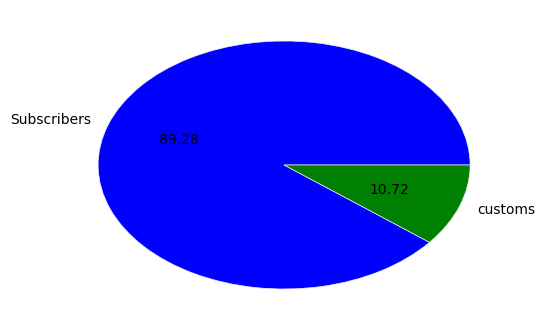

In [13]:
totals = merged_st['Subscriber Type'].value_counts()
_ = plt.pie(totals, labels= ['Subscribers', 'customs'], autopct= '%.2f')
#plt.savefig('./Pictures/by_types.png') #run it only once

In [15]:
#If someone wants to get plotly pie chart.
Subscribers, Customers = totals[0], totals[1]

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
    'data': [{'labels': ['Subscribers', 'Customers'],
              'values': [Subscribers, Customers],
              'type': 'pie'}],
    'layout': {'title': 'Trip counts by customer types'}
     }

py.iplot(fig)

### trip counts by cities

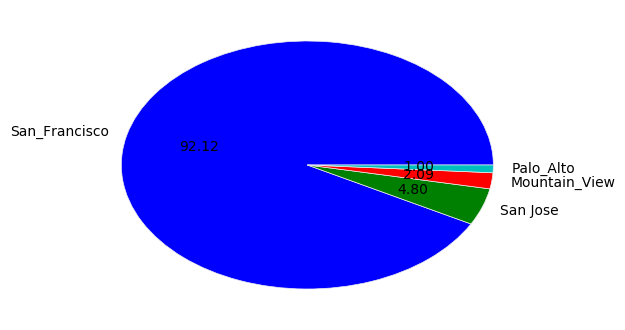

In [14]:
by_cities = merged_st.landmark.value_counts()
_ = plt.pie(by_cities, labels=['San_Francisco', 'San Jose', 'Mountain_View', 'Palo_Alto'], autopct='%.2f')
#plt.savefig('./Pictures/by_cities.png') #run it only once

In [18]:
#if someone wants plotly plot.
sf, sj, mv, pa = by_cities[0], by_cities[1], by_cities[2], by_cities[3]
fig_cities = {
    'data': [{'labels': ['San Francisco', 'San Jose', 'Mountain View', 'Palo Alto'],
              'values': [sf, sj, mv, pa],
              'type': 'pie'}],
    'layout': {'title': 'Trip counts by cities'}
     }

py.iplot(fig_cities)

### most popular five starting stations

In [15]:
merged_st.name.value_counts()[:5]

San Francisco Caltrain (Townsend at 4th)    23591
San Francisco Caltrain 2 (330 Townsend)     22358
Harry Bridges Plaza (Ferry Building)        16128
2nd at Townsend                             14099
Steuart at Market                           13693
Name: name, dtype: int64

<h3> Bay Area Bike Share map </h3>
To get better sense of Bike Stations, let's create station maps. To this end, I am creating the geoJSON file which I later transfer to gist and create an interactive plot.

In [16]:
def parser(df):
    """
    Parses a pandas DF into JSON-line object
    input: a dataframe
    output: JSON-line object
    """
    fields = df.columns
    parsed_data = (dict(zip(fields, df.iloc[i])) for i in xrange(len(df)))
    return parsed_data


def create_map(df):
    """
    Creates a map for the given data frame
    input: a data frame
    output: a message: "geoJSON file has been created, check out your cd"
    """
    
    geo_map = {'type': 'FeatureCollection'}
    items = list()
    for index, line in enumerate(parser(df)):
        #Skip any zero coordinates as this will throw off our map
        if line['long'] == str(0) or line['lat'] == str(0):
            continue
        
        data = {}
        data['type'] = 'Feature'
        data['id'] = index
        year = line['installation'].split('/')[2]
        if line['station_id'] == 70 or line['station_id'] == 69:
            data['properties'] = {'name': line['name'],
                             'dockcount': line['dockcount'],
                          'trip_counts' : line['trip_counts'],
                          'marker-color':'#a11f27'
                                 }
        elif year == '2013':
            data['properties'] = {'name': line['name'],
                             'dockcount': line['dockcount'],
                          'trip_counts' : line['trip_counts'],
                          'marker-color':'#0e2f44'
                                 }
        else:
            data['properties'] = {'name': line['name'],
                             'dockcount': line['dockcount'],
                          'trip_counts' : line['trip_counts']
                                 }
        data['geometry'] = {'type': 'Point',
                     'coordinates': (line['long'], line['lat'])
                          }
        items.append(data)
    #for each point in our items, we add the point to our dictionary
    for point in items:
        geo_map.setdefault('features', []).append(point)

    #Now that we've build up our geo_map dictionary, let's save it as geojson file
    with open('sfbikestations.geojson', 'w') as f:
            f.write(dumps(geo_map))
    return "geoJSON file has been created, check out your cd"

In [17]:
trip_counts = pd.DataFrame(merged_st.sort_values(by = 'station_id').station_id.value_counts())
trip_counts = trip_counts.reset_index().rename(columns = {'station_id' : 'trip_counts',
                                                          'index' : 'station_id'})
station_merged = pd.merge(station, trip_counts, on = 'station_id')
station_merged.columns

Index([u'station_id', u'name', u'lat', u'long', u'dockcount', u'landmark',
       u'installation', u'trip_counts'],
      dtype='object')

In [24]:
create_map(station_merged)

'geoJSON file has been created, check out your cd'

Now, use the newly created geoJSON file and create a map with https://gist.github.com

####The map can be seen only in HTML formatted file
script src="https://gist.github.com/akimbekov/557babc67daed3b6a40b75c0e88dda33.js"></script

#### plots to generate average bike and dock counts per day, month for 4 cities and 2 most popular stations

In [24]:
def status_for_city(status, station, city = 'San Francisco'):
    """
    returns a dataframe station ids for the specified city
    
    input: status and station dataframes, city (default = 'San Francisco')
    output: a stations dataframe with for the specified city
    
    """
    
    city_stations = station[station.landmark == city]['station_id']
    city_status = status[status.station_id.isin(city_stations)]
    
    return city_status

def group_plot(status, term):
    """
    plots average availability of bikes and docks per term
    
    input: status dataframe, a term ('H' = for hour, 'm' = for month) by which to group
           note: status.time should have datetime format
    output: plot of average bikes/dock available across sites grouped by a term
    """
    if term is 'H':
        xmin, xmax = 0, 23
        title = 'Average availability of bikes and docks throughout a day'
    elif term is 'm':
        xmin, xmax = 1, 12
        title = 'Average availability of bikes and docks throughout a year'
    #format datetime to suitable using input term.
    status['term'] = status.time.dt.strftime('%{}'.format(term))
    grouped_by_term = status.groupby('term').mean()
    grouped_by_term.reset_index(inplace = True)
    
    #plot subplots for docks and bikes
    plt.figure(1)
    plt.subplot(211)
    plt.plot(grouped_by_term.term, grouped_by_term.docks_available, linewidth = 3)
    plt.subplot(211)
    plt.plot(grouped_by_term.term, grouped_by_term.bikes_available, linewidth = 3)
    plt.rc('xtick', labelsize = 20)
    plt.rc('ytick', labelsize = 20)
    plt.xlim(xmin=xmin, xmax = xmax)
    plt.legend(loc = 'upper left')
    plt.title(title)
    plt.rcParams['figure.figsize'] = 18, 10
    return 'see plot'

In [21]:
#Takes 7 - 10 mins depending on your machine's specs
status.time = pd.to_datetime(status.time, infer_datetime_format = True)

## San Francisco

In [22]:
sf_status = status_for_city(status, station)

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

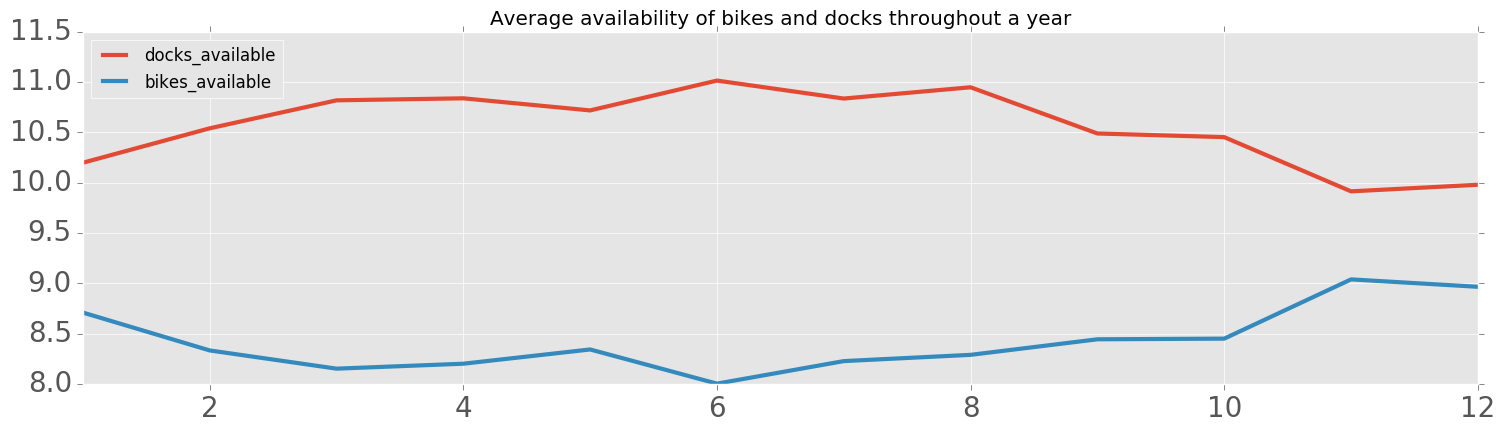

In [25]:
#takes 2-3 mins
group_plot(sf_status, 'm')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

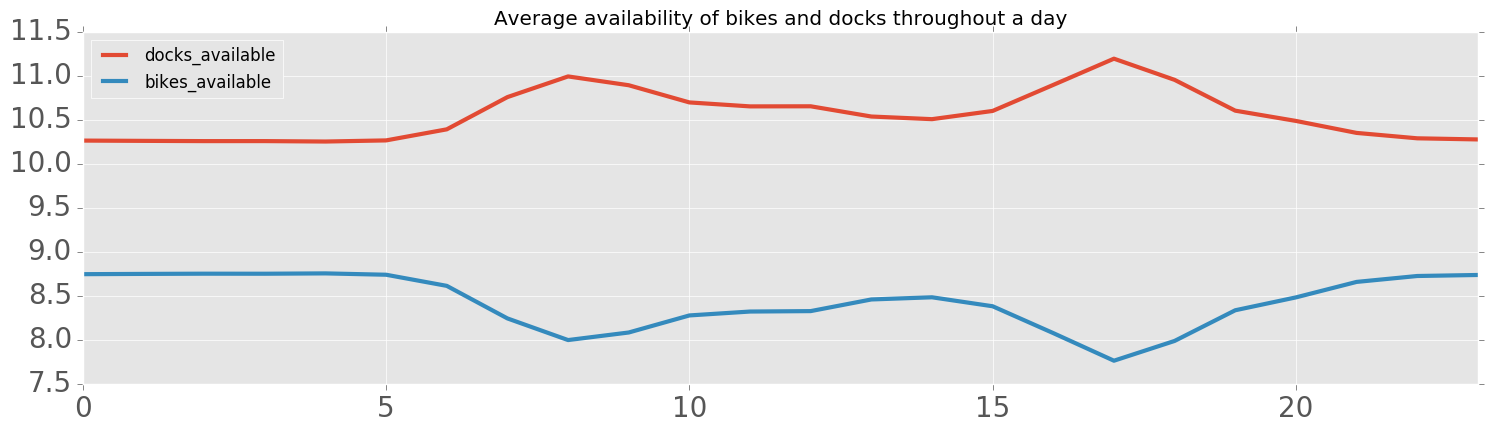

In [33]:
#takes 2-3 mins
group_plot(sf_status, 'H')

Two most busiest stations in San Francisco: San Francisco Caltrain 2 (330 Townsend) and San Francisco Caltrain (Townsend at 4th)

In [27]:
#San Francisco Caltrain 2 (330 Townsend)
sf_stat69 = sf_status[sf_status.station_id == 69]

#San Francisco Caltrain (Townsend at 4th)
sf_stat70 = sf_status[sf_status.station_id == 70]

## San Francisco Caltrain 2 (330 Townsend) 

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

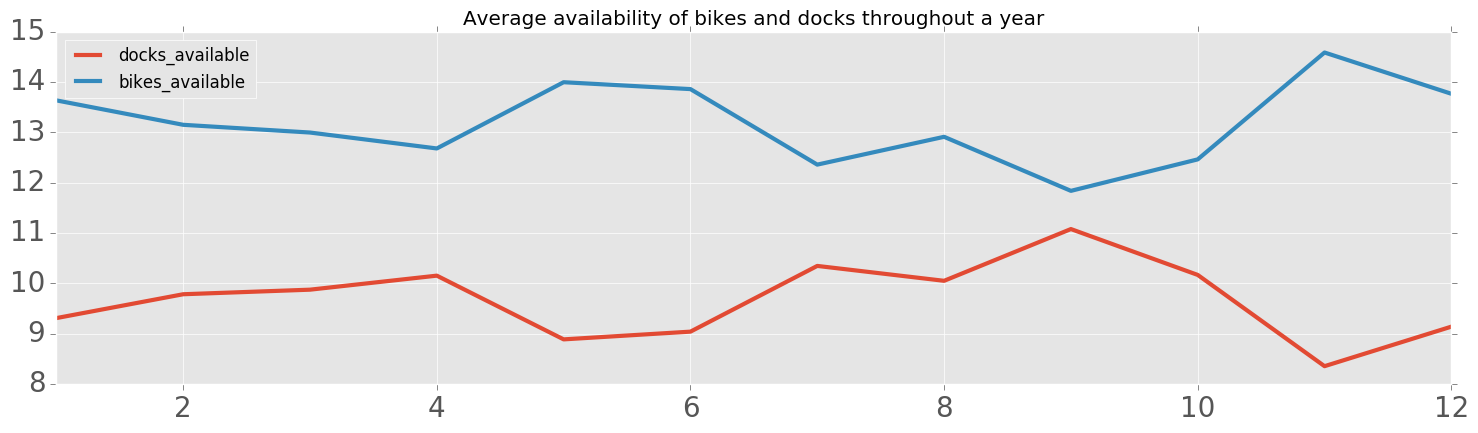

In [29]:
group_plot(sf_stat69, 'm')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

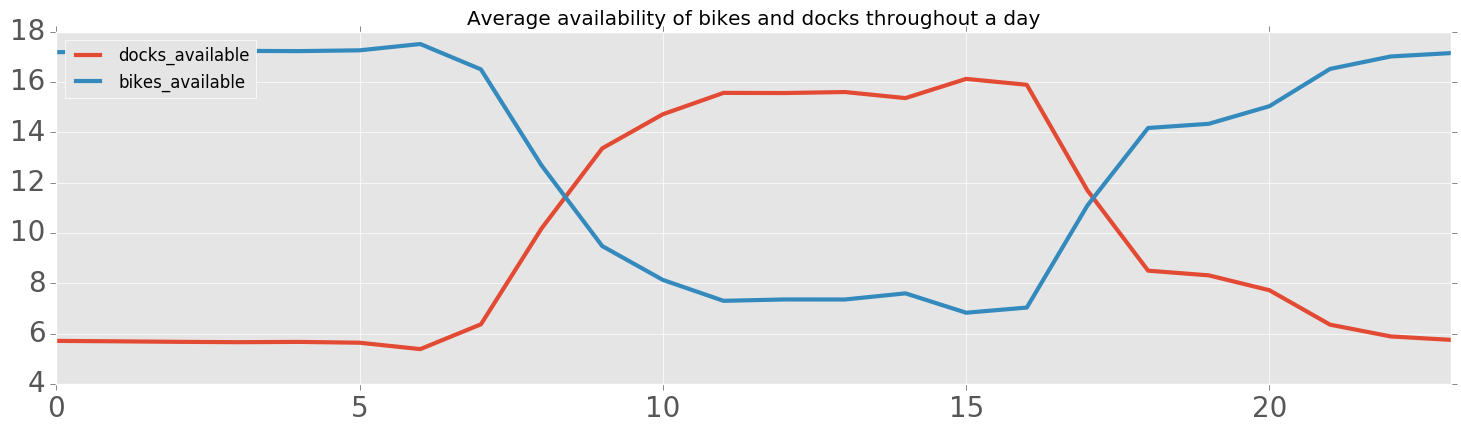

In [30]:
group_plot(sf_stat69, 'H')

## San Francisco Caltrain (Townsend at 4th)

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

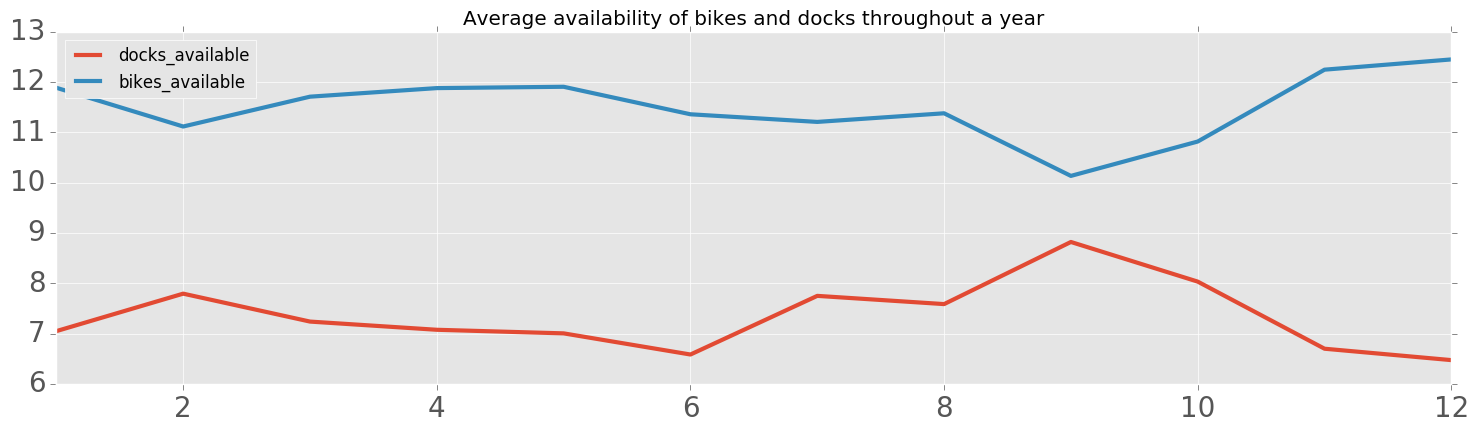

In [31]:
group_plot(sf_stat70, 'm')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

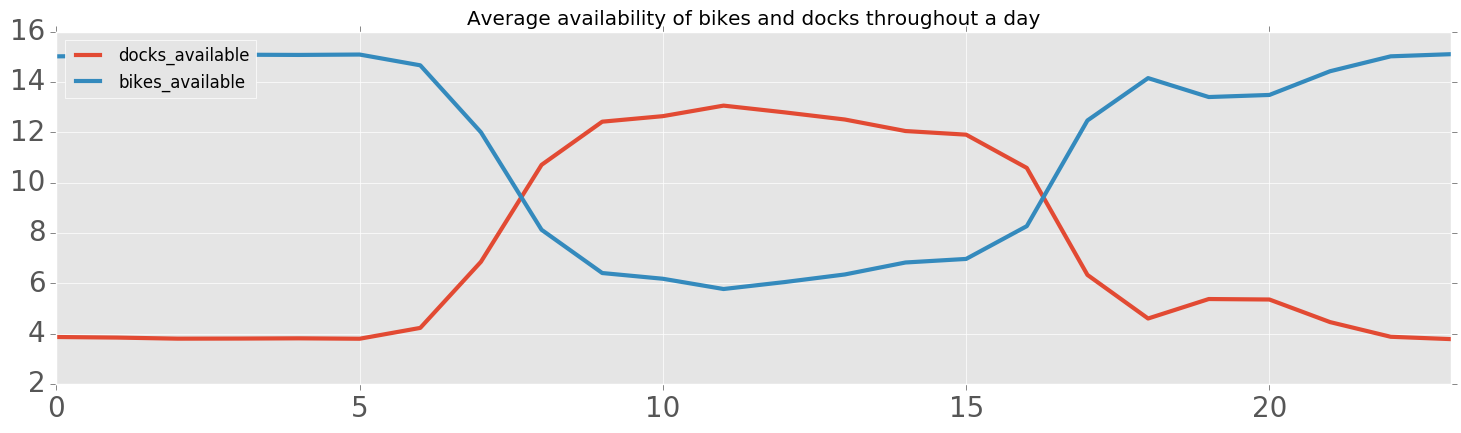

In [32]:
group_plot(sf_stat70, 'H')

# San Jose

In [34]:
s_jose = status_for_city(status, station, 'San Jose')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

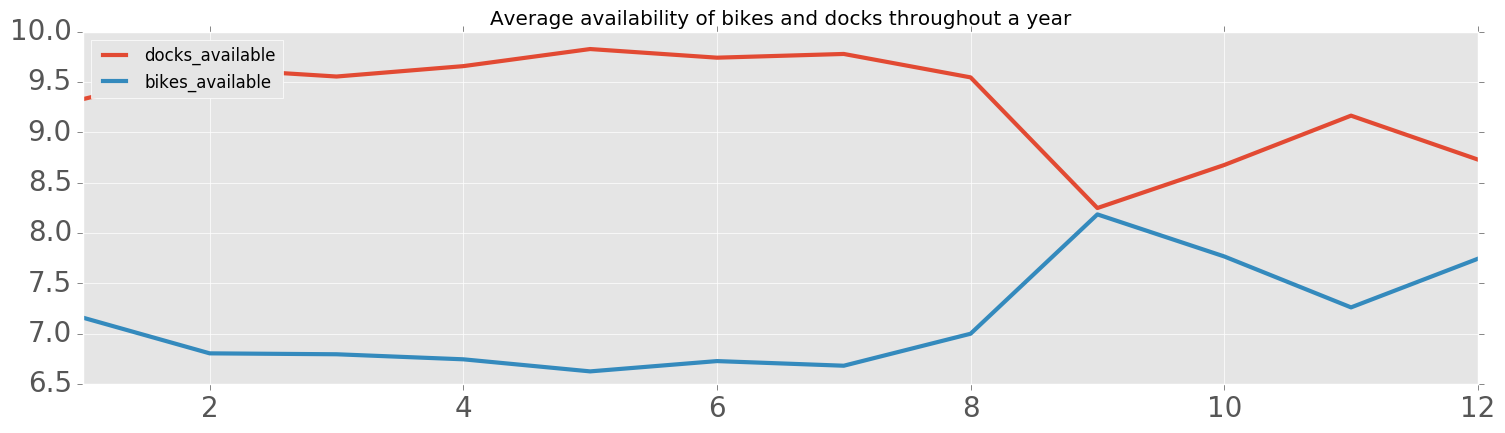

In [35]:
group_plot(s_jose, 'm')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

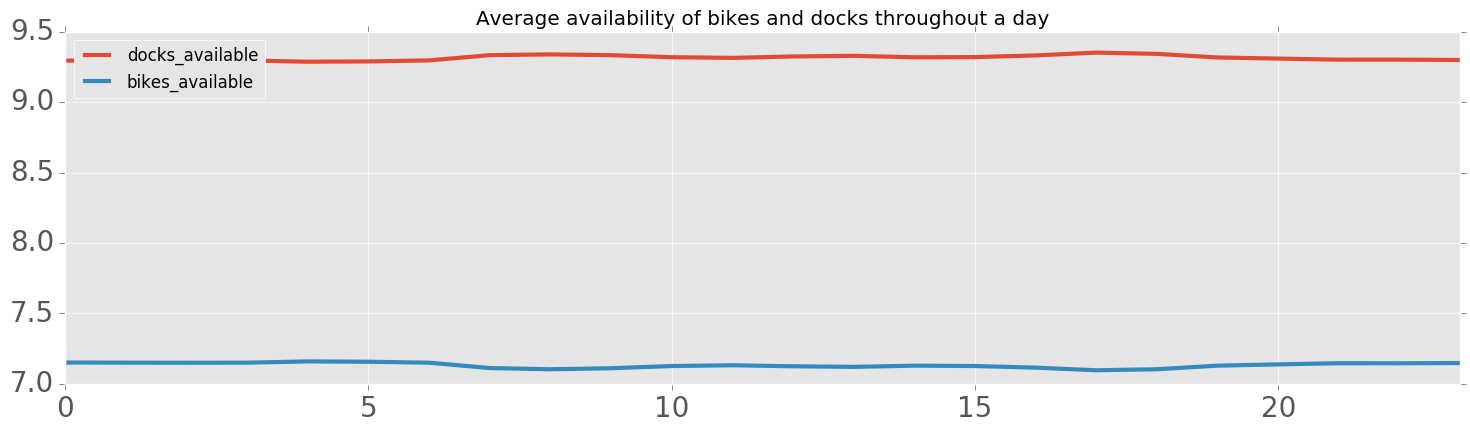

In [36]:
group_plot(s_jose, 'H')

# Palo Alto

In [38]:
p_alto = status_for_city(status, station, 'Palo Alto')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

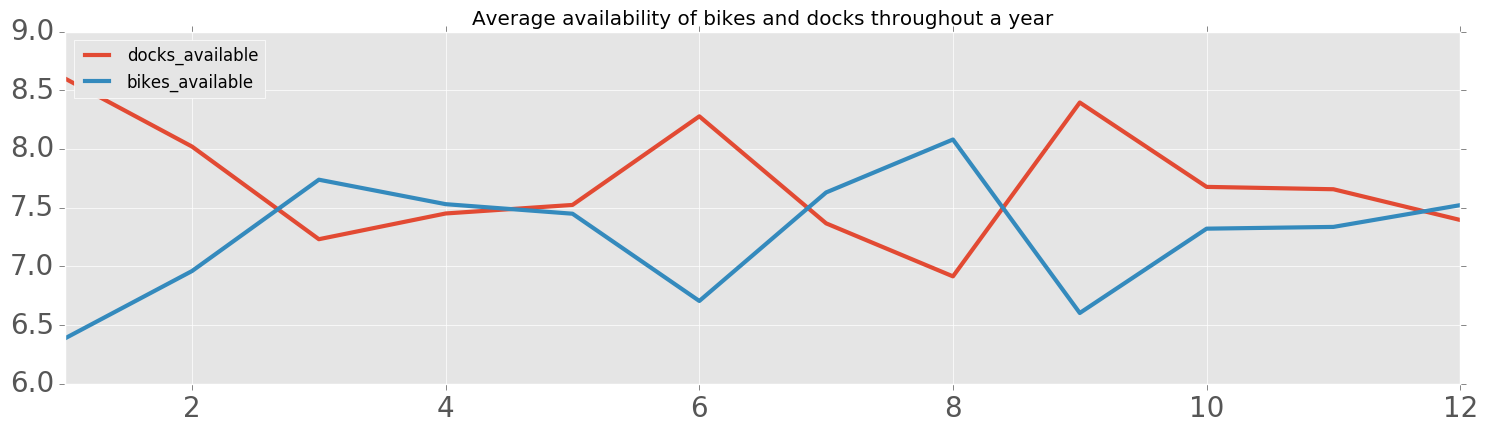

In [39]:
group_plot(p_alto, 'm')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

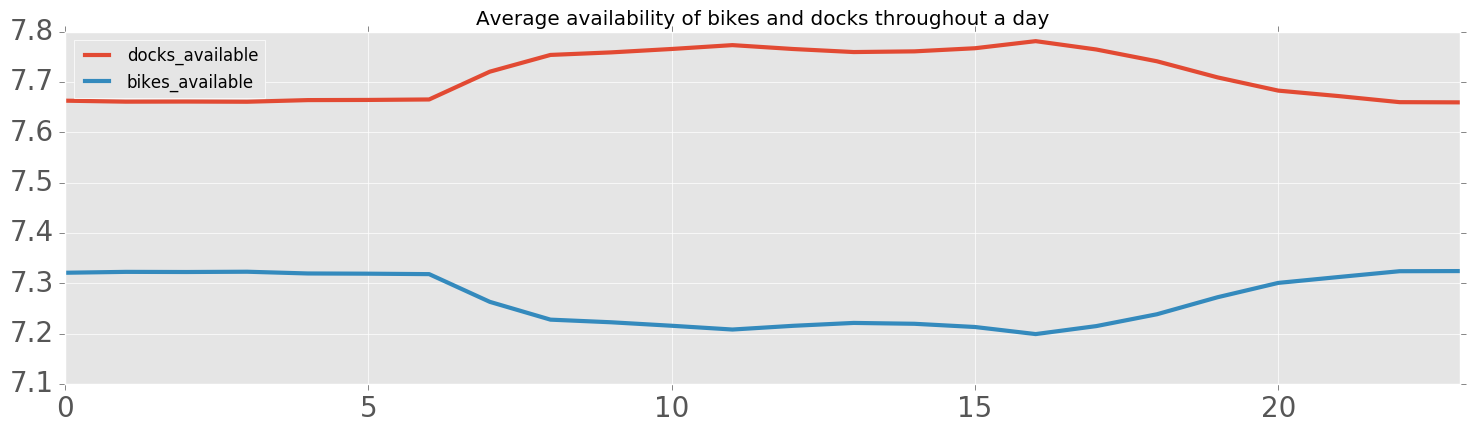

In [40]:
group_plot(p_alto, 'H')

# Mountain View

In [41]:
m_view = status_for_city(status, station, 'Mountain View')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

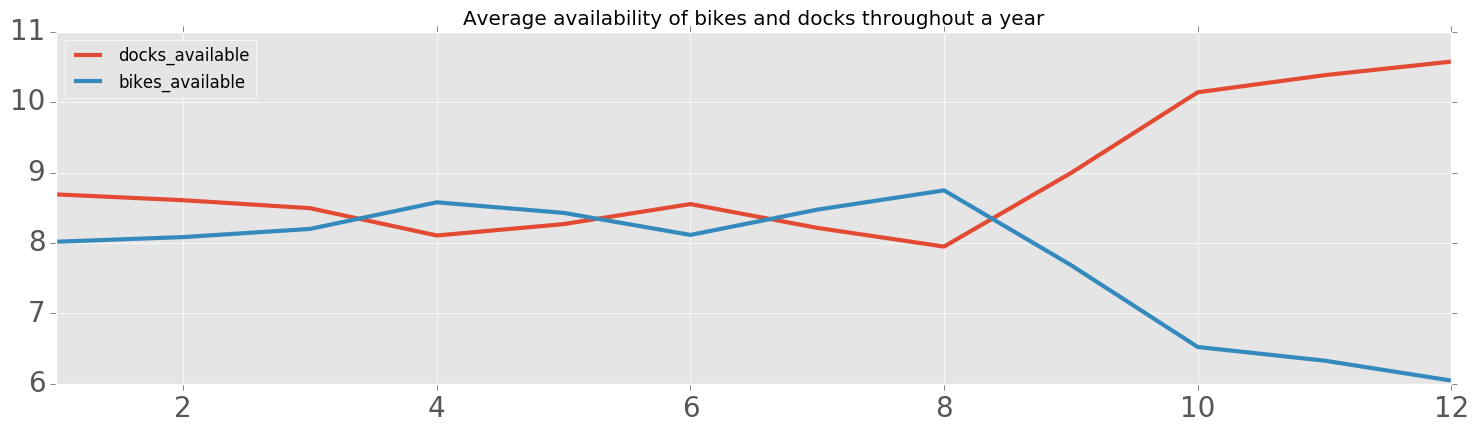

In [42]:
group_plot(m_view, 'm')

/Users/admin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'see plot'

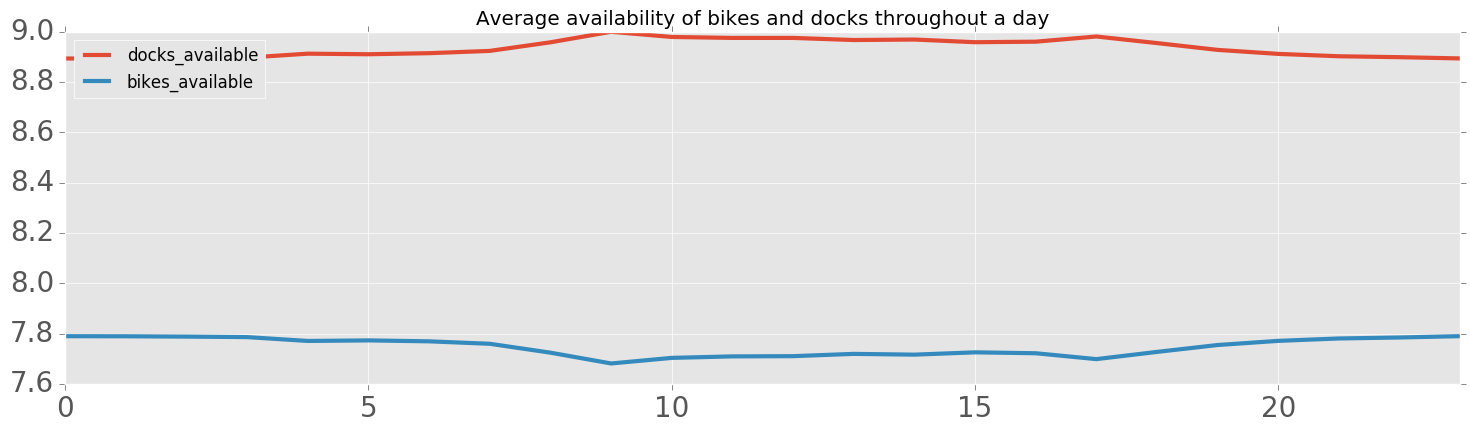

In [43]:
group_plot(m_view, 'H')

# ASHKAN'S CODES

<h3>Read the data</h3>

In [9]:
path = '../Project_Datasets'

In [10]:
station, status, trip, weather = read_data(path, 2016)

<h3>Plot stations on map</h3>

In [12]:
def plot_station(df, city):
    '''
    This function plots the stations available in each city
    @args:
        df: is the data frame containing the stations information such as their name and latitude and longitudes
        city: name of city of intrests among: San Jose, San Francisco, Palo Alto, Mountain View
    @returns:
        a map plot of stations
    '''
    path = '/Users/ashkansaboori/Documents/OneDrive/MyPhD/Courses/5 Winter-2017/STA 141B/Project/SF_bike_share/Pictures/'
    file_name = path + city + '_map'
    df = df[df.landmark == city]
    data = df[['name', 'lat', 'long']].dropna()
    data = data.rename(columns={'long':'lon'})
    geoplotlib.dot(data, point_size=4)
    #geoplotlib.show()
    return geoplotlib.savefig(file_name)

In [17]:
plot_station(station, 'San Francisco')

<h3>Plot trips on map</h3>

In [27]:
def plot_trip(station, trip, city):
    '''
    This function plots the 
    '''
    
    path = '/Users/ashkansaboori/Documents/OneDrive/MyPhD/Courses/5 Winter-2017/STA 141B/Project/SF_bike_share/Pictures/'
    file_name = path + city + '_trips'
    
    station = station[station.landmark == city]
    start_trip_end = trip[['Start Station', 'End Station']].drop_duplicates().dropna()
    #Remove trips that start and end stations are the same
    start_trip_end = start_trip_end[~(start_trip_end['Start Station'] == start_trip_end['End Station'])]
    start_trip = pd.DataFrame(start_trip_end['Start Station'])
    end_trip = pd.DataFrame(start_trip_end['End Station'])

    start_trip_end = pd.merge(left = station[['name', 'lat', 'long']], right = start_trip_end, how = 'inner', left_on='name', right_on='Start Station')
    start_trip_end = start_trip_end.rename(columns = {'long': 'lon_departure', 'lat': 'lat_departure'})
    
    start_trip_end = pd.merge(left = station[['name', 'lat', 'long']], right = start_trip_end, how = 'inner', left_on='name', right_on='End Station')
    start_trip_end = start_trip_end.rename(columns = {'long': 'lon_arrival', 'lat': 'lat_arrival'})
    start_trip_end = start_trip_end[['lon_departure', 'lat_departure', 'lon_arrival', 'lat_arrival']]
    
    geoplotlib.graph(start_trip_end,
                 src_lat='lat_departure',
                 src_lon='lon_departure',
                 dest_lat='lat_arrival',
                 dest_lon='lon_arrival',
                 color='hot_r',
                 alpha=16,
                 linewidth=3)
    return geoplotlib.savefig(file_name)

In [29]:
plot_trip(station, trip, 'Mountain View')

<h3>Station trip count</h3>

In [ ]:
def OneTrip_count(stationDF, tripDF, tripType):
    '''
    This function computes the number of departure or arrival trip for each station
    @args:
        staionDF: station dataframe
        tripDF: trip dataframe
        tripType: which shows whether is departure or arrival. The value could be: "Start Terminal" or "End Terminal"
    @returns:
        a dataframe containing the number of trip and dock for each station
    '''
    
    if tripType == 'Start Terminal':
        count = 'departure_count'
    else:
        count = 'arrival_count'
        
    dockCount = stationDF[['station_id', 'name', 'dockcount']]
    tripCount = tripDF.groupby(tripType).agg(['count'])['Trip ID']
    #Convert the index to column
    tripCount.reset_index(level=0, inplace=True)
    tripCount=tripCount.rename(columns = {tripType: 'station_id', 'count': count})
    result = pd.merge(left = dockCount, right = tripCount, how = 'inner', on= 'station_id')
    return result

In [ ]:
def TwoTrip_count(stationDF, tripDF):
    '''
    This function computes the number of both departure and arrival trips for each station
    @args:
        staionDF: station dataframe
        tripDF: trip dataframe
    @returns:
        a dataframe containing the number of trip and dock for each station
    '''
    
    tripCount =pd.merge(left=OneTrip_count(stationDF, tripDF,'Start Terminal'), 
                        right=OneTrip_count(stationDF, tripDF,'End Terminal'), 
                    on=['station_id', 'dockcount'], how='inner')
    del tripCount['name_y']
    tripCount = tripCount.rename(columns={'name_x': 'station name'})
    return tripCount.sort_values('station_id')

In [ ]:
TwoTrip_count(station, trip)

<h3>Most popular routes</h3>

In [12]:
#Find top three routes for each station
popular_routes = trip.groupby(['Start Terminal', 'End Terminal']).agg({'Trip ID': 'count', 'Duration': 'mean'}).reset_index().sort_values(['Start Terminal', 'Trip ID'], ascending = [1,0])
popular_routes = popular_routes[popular_routes['Start Terminal'] != popular_routes['End Terminal']].groupby('Start Terminal').head(3)
popular_routes = popular_routes.rename(columns={'Trip ID': 'Counts'})
popular_routes.Duration = popular_routes['Duration'].apply(lambda x: round((x/60),2))

In [13]:
#Add name, latitude and longitude of the start_station
popular_routes=pd.merge(left = popular_routes, right = station[['station_id', 'name', 'lat', 'long']], 
         how='inner', left_on='Start Terminal', right_on='station_id')
del popular_routes['station_id']
popular_routes = popular_routes.rename(columns={'name': 'start_name', 'lat': 'start_lat', 'long': 'start_lon'})

In [14]:
#Add name, latitude and longitude of the end_station
popular_routes=pd.merge(left = popular_routes, right = station[['station_id', 'name', 'lat', 'long']], 
         how='inner', left_on='End Terminal', right_on='station_id')
del popular_routes['station_id']
popular_routes = popular_routes.rename(columns={'name': 'end_name', 'lat': 'end_lat', 'long': 'end_lon'})

In [15]:
#Hover text for stations
station_hover_text = station.dropna().apply(lambda x: 'Station: {}<br>Dockcount: {}'.format(x[1], int(x[4])), axis = 1)

In [16]:
#Find the middle of the map for graph
lat_center = (popular_routes.start_lat.sum() + popular_routes.end_lat.sum())/(2*len(popular_routes))
lon_center = (popular_routes.start_lon.sum() + popular_routes.end_lon.sum())/(2*len(popular_routes))

In [17]:
#Define stations object
station_graph = go.Scattermapbox(lon = station['long'],
                    lat = station['lat'],
                    hoverinfo = 'text',
                    text = station_hover_text,
                    mode = 'markers',
                    marker = dict(size = 12,
                                 color = 'blue'
                                  ),
                    opacity = 0.3)

In [18]:
#Define ride path object
#Empty list for flight path objects
ride_path = []
for i in range(len(popular_routes)):
    data = go.Scattermapbox(lon = [popular_routes['start_lon'][i], popular_routes['end_lon'][i]],
                           lat = [popular_routes['start_lat'][i], popular_routes['end_lat'][i]],
                           mode = 'lines',
                           line = dict(width = 1,
                                      color = 'red'),
                           opacity = float(popular_routes['Counts'][i])/float(popular_routes['Counts'].max()))
    ride_path.append(data)

In [19]:
data = go.Data(ride_path + [station_graph])
#data = go.Data([station_graph])
#Define the layout
layout = dict(
    title = 'Top Three Busy Routes for Stations<br>San Francisco, San Jose, Palo Alto, and Mountain View',
    showlegend = False,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=dict(
            lat=lat_center,
            lon=lon_center
        ),
        pitch=0,
        zoom=5
    ),
)
layout = go.Layout(layout)

In [ ]:
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

<h3>Crime analysis</h3>

In [11]:
crime = pd.read_csv('/Users/ashkansaboori/Documents/OneDrive/MyPhD/Courses/5Winter-2017/STA141B/Project/Project_Datasets/Crime_Incidents/Crime Incidents.csv')

In [21]:
#List of related crimes
relatedCrimes = ['BURGLARY', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'STOLEN PROPERTY', 'VANDALISM', 'VEHICLE THEFT']
bikeCrime = crime[crime['Category'].isin(relatedCrimes)].reset_index(drop = True)
#Extract year from "Date" column
bikeCrime.Date = bikeCrime.Date.str.slice(6,10)
bikeCrime = bikeCrime.rename(columns = {'X': 'lon', 'Y': 'lat', 'Date': 'year'})
#Crimes in year 2016
bikeCrime = bikeCrime[bikeCrime['year'] == '2016'][['Category', 'lat', 'lon']]

In [22]:
#Assign color for each crime
def color(crimeType):
    if crimeType == 'BURGLARY':
        return 'red'
    elif crimeType == 'DRIVING UNDER THE INFLUENCE':
        return 'green'
    elif crimeType == 'ROBBERY':
        return 'blue'
    elif crimeType == 'STOLEN PROPERTY':
        return 'purple'
    elif crimeType == 'VANDALISM':
        return 'yellow'
    else:
        return 'black'

In [23]:
color = [color(x) for x in bikeCrime.Category]

In [24]:
crime_graph = go.Scattermapbox(lon = bikeCrime['lon'],
                    lat = bikeCrime['lat'],
                    hoverinfo = 'text',
                    text = bikeCrime['Category'],
                    mode = 'markers',
                    marker = dict(size = 5,
                                 color = 'red'
                                  ),
                    opacity = 0.1)
data = go.Data([crime_graph])

In [25]:
layout = dict(
    title = 'Crime Map in San Francisco',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=dict(
            lat=37.773972,
            lon=-122.431297
        ),
        pitch=0,
        zoom=5
    ),
)
layout = go.Layout(layout)

In [ ]:
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

<h3>Income Analysis</h3>

In [ ]:
#Source of data: http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/
#Also this can be useful: http://www.psc.isr.umich.edu/dis/data/kb/answer/1123
income = pd.read_csv('/Users/ashkansaboori/Documents/OneDrive/MyPhD/Courses/5Winter-2017/STA141B/Project/Project_Datasets/Income/Income.csv', header=0)

In [ ]:
def extract_info(zipNum, info_type):
    '''
    This function gets the zipcode and returns either city name, latitude, or longitude
    @args:
        zipNum: zipcode
        info_type: could be either: 'city', 'lat', or 'longitude'
    @returns:
        city name, latitude, or longitude
    '''
    
    try:
        zipcode.isequal(str(zipNum)).state #Check to see if info exists for the zipcode
        info = zipcode.isequal(str(zipNum))
    except AttributeError:
        return 'Not valid'
    if info_type == 'state':
        return info.state
    if info_type == 'city':
        return info.city
    elif info_type == 'lat':
        return info.lat
    else:
        return info.lon

In [ ]:
#Add state, city, latitude, and longitude columns to income dataset
info_list = ['state', 'city', 'lat', 'lon']
for i in info_list:
    income[i] = [extract_info(str(x), i) for x in income.iloc[:,0]]

#Extract Sanfrancicso data
SF_income = income[(income.state == 'CA') & (income.city == 'SAN FRANCISCO')].reset_index(drop=True)

#Change Median, Mean, and Population type to integer
#SF_income['Mean_int'] = SF_income['Mean'].str.replace(',', '').apply(int)
#SF_income['Median_int'] = SF_income['Median'].str.replace(',', '').apply(int)
#SF_income['Population_int'] = SF_income['Population'].str.replace(',', '').apply(int)

In [ ]:
#For hover in the map graph
text_income = SF_income.apply(lambda x: 'Zipcode: {}<br>Population: {}<br>Median Income: ${}<br>Mean Income: ${}'.format(
        x[0], x[3], x[1], x[2]),axis=1)

In [ ]:
#Scale the point size for map
point_size = SF_income['Median'].str.replace(',', '').apply(int)/SF_income['Median'].str.replace(',', '').apply(int).max()

In [ ]:
#Scale the point transparancy to population
point_transparency = SF_income['Population'].str.replace(',', '').apply(int)/SF_income['Population'].str.replace(',', '').apply(int).max()

In [ ]:
income_graph = go.Scattermapbox(lon = SF_income['lon'],
                    lat = SF_income['lat'],
                    hoverinfo = 'text',
                    text = text_income,
                    mode = 'markers',
                    marker = dict(size = point_size*20,
                                 color = 'light blue'
                                  ),
                    opacity = point_transparency/10,
                    name = 'Median Income')
data = go.Data([income_graph, crime_graph])

In [ ]:
layout = dict(
    title = 'Median Income Map in San Francisco',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=dict(
            lat=37.773972,
            lon=-122.431297
        ),
        pitch=0,
        zoom=10
    ),
)
layout = go.Layout(layout)

In [ ]:
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

<h3>Map with Folium</h3>

In [ ]:
#For popup in the map graph
text_income = SF_income.apply(lambda x: 'ZipCode: {}{}Population: {}{}Median Income: ${}{}Mean Income: ${}'.format(
        x[0], 40*' ', x[3], 20*' ', x[1], 20*' ', x[2]),axis=1)

In [ ]:
SF_station = station[station.landmark == 'San Francisco'].dropna().reset_index(drop = True)

In [ ]:
SF_station = pd.merge(left = SF_station, right=TwoTrip_count(station, trip)[['station_id', 'departure_count', 'arrival_count']],
        on = 'station_id')

In [ ]:
text_station = SF_station.apply(lambda x: '<font size="2" face="verdana"><b>Station:</b> {}<br><b>Dock Count:</b> {}<br><b>Departure Count:</b> {}<br><b>Arrival Count:</b> {}</font>'.format(
        x[1], x[4], x[-2], x[-1]),axis=1)

In [ ]:
map = folium.Map(location = [37.773972, -122.431297], 
                 tiles= 'OpenStreetMap', zoom_start=12)

In [ ]:
for i in range(len(bikeCrime)):
    folium.CircleMarker([bikeCrime.lat[i], bikeCrime.lon[i]]
                       ,radius = 3,
                       color='red',
                       fill_color = 'red').add_to(map)

In [ ]:
for i in range(len(SF_station)):
    iframe = folium.element.IFrame(html=text_station[i], width=330, height=85)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker([SF_station.lat[i], SF_station.long[i]],
                 icon=folium.Icon(color='green'),
                 popup = popup).add_to(map)

In [ ]:
for i in range(len(SF_income)):
    popup = folium.Popup(text_income[i], max_width=140)
    folium.CircleMarker([SF_income.lat[i], SF_income.lon[i]],
                        radius = point_size[i]*250,
                        popup = popup,
                        color='#3186cc',
                        fill_color='#3186cc',
                   ).add_to(map)

In [ ]:
map

# PAM'S CODES

In [8]:
path = '~/Dropbox/141B/Project/data'

In [9]:
#more imports: Pam's additions
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import parser
import math
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [5]:
import plotly.plotly as py
from plotly.graph_objs import *

trace0 = Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = Data([trace0, trace1])

py.iplot(data, filename = 'basic-line')


High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~pamelot317/0 or inside your plot.ly account where it is named 'basic-line'


In [10]:
station15, status15, trip15, weather15 = read_data(path, 2015)

In [11]:
station15.head()

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [12]:
status15.head()

,station_id,bikes_available,docks_available,time
0,2,15,12,2014-09-01 00:00:03
1,2,15,12,2014-09-01 00:01:02
2,2,15,12,2014-09-01 00:02:02
3,2,15,12,2014-09-01 00:03:03
4,2,15,12,2014-09-01 00:04:02


In [13]:
trip15.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069


In [14]:
weather15.head()

,PDT,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,9/1/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0,0.0,NaN,290.0,94107
1,9/2/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0,5.0,NaN,290.0,94107
2,9/3/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0,4.0,NaN,276.0,94107
3,9/4/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0,5.0,NaN,301.0,94107
4,9/5/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0,4.0,NaN,309.0,94107


In [15]:
station15['year']='2015'
status15['year'] = '2015'
trip15['year'] = '2015'
weather15['year'] = '2015'

In [16]:
trip15['Count'] = 1
trip15['Date'] = ''

In [17]:
trip15['Date'] = trip15.apply(lambda x:  x.loc[('Start Date')].split()[0], axis=1)

In [18]:
trip15.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,year,Count,Date
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,2015,1,8/31/2015
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032,2015,1,8/31/2015
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107,2015,1,8/31/2015
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113,2015,1,8/31/2015
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069,2015,1,8/31/2015


In [19]:
total_rides15 = trip15[['Count', 'Date']]
total_rides15 = total_rides15.set_index('Date')
total_rides15 = total_rides15.groupby(level = 0).sum()

In [20]:
total_rides15.head()

,Count
Date,
1/1/2015,181
1/10/2015,362
1/11/2015,327
1/12/2015,1344
1/13/2015,1368


In [21]:
weather15 = weather15.rename(index=str, columns={'PDT': 'Date',})

In [22]:
weather15.head(1)

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip,year
0,9/1/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,8.0,16.0,7.0,20.0,0,0.0,NaN,290.0,94107,2015


In [23]:
weather15 = weather15.set_index('Date')

In [24]:
weather15 = weather15.set_index('Zip', append = True)

In [25]:
weather15.shape

(1825, 23)

In [26]:
weather15.xs('9/1/2014', level = 'Date')

,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,year
Zip,,,,,,,,,,,,,,,,,,,,,
94107,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,...,10.0,8.0,16.0,7.0,20.0,0,0.0,NaN,290.0,2015
94063,89.0,74.0,60.0,64.0,56.0,52.0,82.0,67.0,27.0,29.86,...,10.0,10.0,12.0,2.0,NaN,0,0.0,NaN,339.0,2015
94301,86.0,72.0,57.0,66.0,63.0,55.0,94.0,69.0,43.0,29.86,...,10.0,10.0,17.0,6.0,22.0,0,0.0,NaN,351.0,2015
94041,85.0,73.0,60.0,60.0,58.0,53.0,84.0,59.0,34.0,29.87,...,10.0,10.0,17.0,5.0,21.0,0,0.0,NaN,342.0,2015
95113,86.0,72.0,58.0,60.0,54.0,50.0,86.0,59.0,31.0,29.86,...,10.0,10.0,17.0,5.0,22.0,0,0.0,NaN,296.0,2015


In [27]:
weather15['PrecipitationIn'] = pd.to_numeric(weather15['PrecipitationIn'].replace('T', 0))

In [28]:
weather15ave = weather15.groupby(level = 'Date').mean()

In [29]:
weather15ave.head()

,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,...,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2015,55.0,44.6,34.0,29.6,24.0,17.8,65.6,45.4,25.2,30.182,...,30.084,10.0,10.0,10.0,12.0,3.8,18.000000,0.000,0.4,228.2
1/10/2015,59.8,53.8,47.4,52.0,48.6,45.6,97.2,84.8,69.0,30.054,...,29.960,10.0,7.4,4.2,8.2,3.0,9.333333,0.000,4.2,309.8
1/11/2015,56.0,50.2,44.0,50.2,47.4,43.4,99.2,91.2,80.2,30.186,...,30.038,9.8,5.4,0.4,9.0,2.2,17.333333,0.000,4.6,196.8
1/12/2015,60.4,51.8,43.0,50.6,46.4,42.0,98.4,84.6,64.6,30.282,...,30.196,10.0,8.6,5.2,8.4,2.0,11.666667,0.004,1.4,252.6
1/13/2015,64.2,53.6,42.6,48.0,43.0,37.8,100.0,70.2,40.0,30.230,...,30.118,10.0,7.4,4.0,14.0,3.0,22.000000,0.000,1.4,176.4


In [30]:
weather15ave.index.values == total_rides15.index.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [31]:
converter = lambda d: matplotlib.dates.datestr2num(d)
vfun = np.vectorize(converter)

In [32]:
num_dates = vfun(weather15ave.index.values)

In [33]:
weather15ave['num_dates'] = num_dates.tolist()

In [34]:
total_rides15['num_dates'] = num_dates.tolist()

In [35]:
total_rides15 = total_rides15.sort_values(by = 'num_dates', ascending = True)

In [36]:
weather15ave = weather15ave.sort_values(by = 'num_dates', ascending = True)

In [34]:
def weather_plot(y1,y2, y2_label):
    """
    Returns dual axis plot with the x axis being the day, the left and right y-axis being inputed by user
    input: y1 is the data for the left-axis; should have 365 entries, sorted by date;
    y2 is the data for the right y-axis; should have 365 entries, sorted by date; 
    y2_label is a string
    output: a graph
    """
    fig, ax1 = plt.subplots(figsize = (15,5))
    x = total_rides15['num_dates']
    #y1 = total_rides15['Count']
    ax1.plot(x, y1, 'b-')
    ax1.set_xlabel('Day')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Total Rides', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    #y2 = weather15ave[y2_label]
    ax2.plot(x, y2, 'r.')
    ax2.set_ylabel(y2_label, color='r')
    ax2.tick_params('y', colors='r')

    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%y'))
    #fig.tight_layout()
    return plt.show()

In [40]:
def weather_plot(y1,y2, y2_label, file_name):
     """
    Returns dual axis plot with the x axis being the day, the left and right y-axis being inputed by user
    input: y1 is the data for the left-axis; should have 365 entries, sorted by date;
    y2 is the data for the right y-axis; should have 365 entries, sorted by date; 
    y2_label is a string
    file_name: string of what to name file in plotly account
    output: a graph
    """

    trace1 = go.Scatter(
        x=total_rides15['num_dates'],
        y=total_rides15['Count'],
        name='Total Rides'
    )
    trace2 = go.Scatter(
        x=total_rides15['num_dates'],
        y=weather15ave[' Mean Wind SpeedMPH'],
        name='Mean Wind Speed',
        yaxis='y2'
    )
    data = [trace1, trace2]
    layout = go.Layout(
        title='Total Rides and Mean Wind Speed by date',
        yaxis=dict(
            title='Total Rides'
        ),
        yaxis2=dict(
            title='Mean Wind Speed',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename= file_name)

IndentationError: unindent does not match any outer indentation level (<ipython-input-40-61918406f206>, line 11)

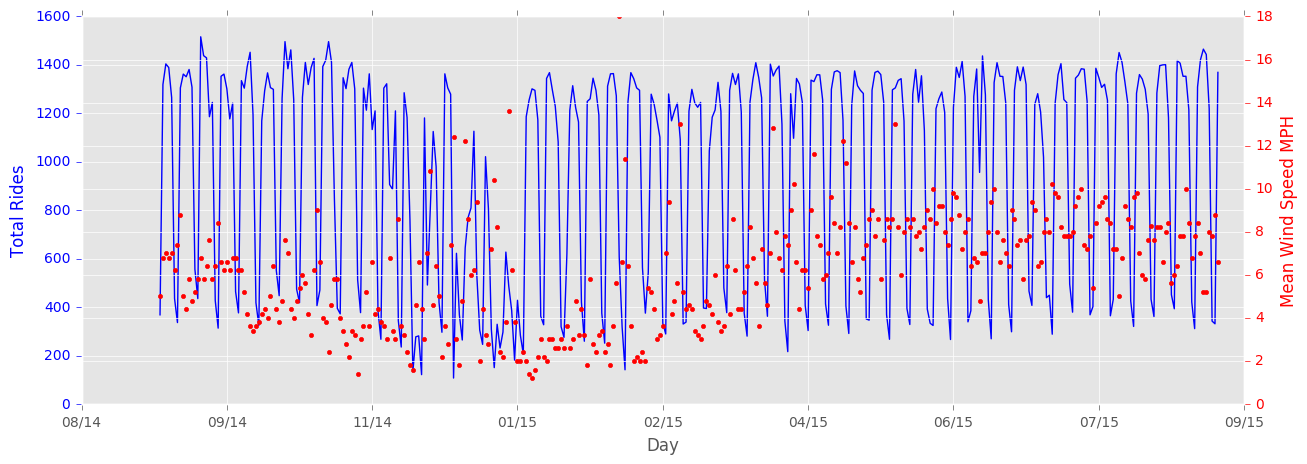

In [35]:
weather_plot(total_rides15['Count'], weather15ave[' Mean Wind SpeedMPH'], 'Mean Wind Speed MPH', 'Wind and Trips')

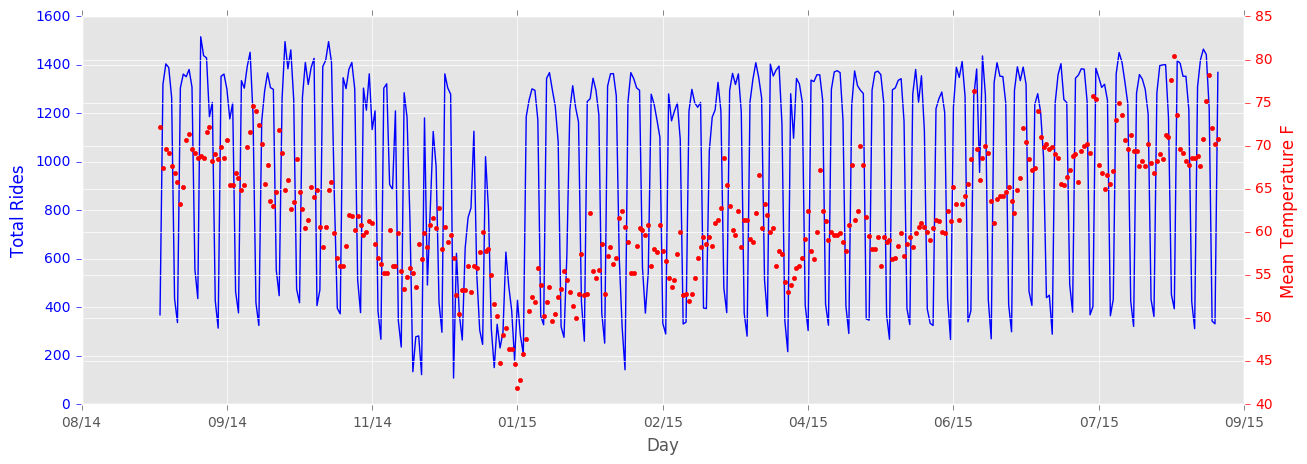

In [36]:
weather_plot(total_rides15['Count'],weather15ave['Mean TemperatureF'], 'Mean Temperature F')

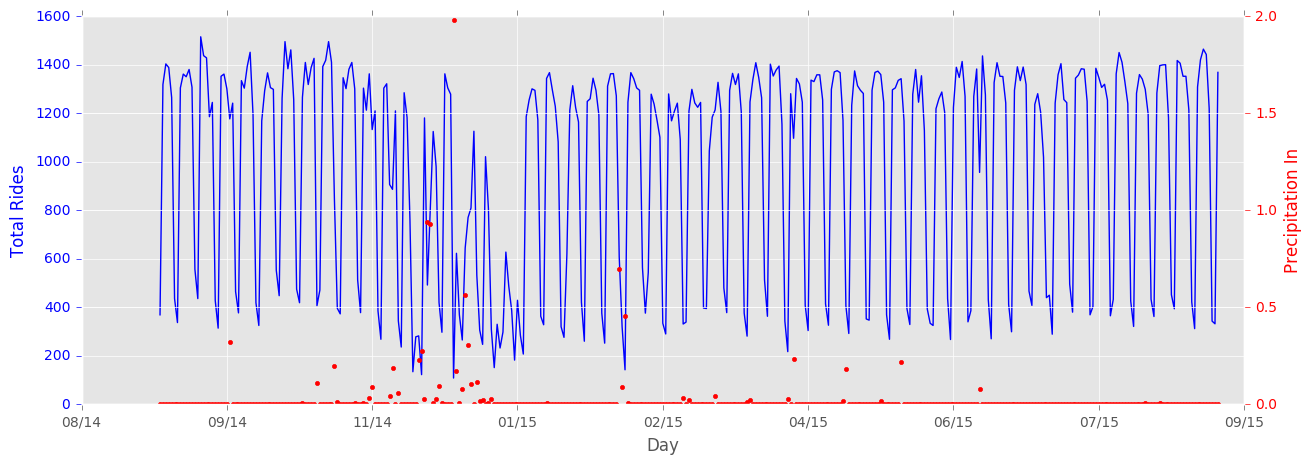

In [37]:
weather_plot(total_rides15['Count'],weather15ave['PrecipitationIn'], 'Precipitation In')

In [38]:
weather15ave.columns.values

array(['Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles',
       ' Min VisibilityMiles', ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH',
       ' Max Gust SpeedMPH', 'PrecipitationIn', ' CloudCover',
       ' WindDirDegrees', 'num_dates'], dtype=object)

In [39]:
weather15.columns.values

array(['Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles',
       ' Min VisibilityMiles', ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH',
       ' Max Gust SpeedMPH', 'PrecipitationIn', ' CloudCover', ' Events',
       ' WindDirDegrees', 'year'], dtype=object)

In [41]:
def anchor(y):
    """Return the anchor day for the given year's century"""
    c = int(str(y)[:2])
    a = (5*(c%4)+2)%7
    return a

def doomsday(y):
    """Compute doomsday for given year"""
    if len(str(y)) != 4:
        d = "Invalid year format"
    else:
        yr = int(str(y)[2:])
        a = anchor(y)
        d = int((yr + math.floor(yr/4) + a)%7)
    return d

def day_of_week(day,month,year):
    """Compute the day of the week from a date"""
    d = doomsday(year)
    week = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
    reg_doomsdays = [10,28,21,4,9,6,11,8,5,10,7,12]
    leap_doomsdays = [11,29,21,4,9,6,11,8,5,10,7,12]
    if (year%4==0 and year%100!=0) or year%400==0:
        closest = leap_doomsdays[month-1]
        difference = abs(closest - day)
        num = int(((difference%7)+ d)%7)
        ans = week[num]
    else:
        closest = reg_doomsdays[month-1]
        difference = abs(closest - day)
        num = int(((difference%7)+ d)%7)
        ans = week[num]
    return ans

In [57]:
testdata = []
for i in range(len(total_rides15.index.values)):
    testdata.append([total_rides15.index.values[i]])

In [60]:
testdata[0][0].strip()

'9'

In [58]:
testdata = [i[0][0].split() for i in testdata]
#testdata = [[int(i) for i in j] for j in testdata]

In [56]:
testdata

[[9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [9],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2]